In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
import ktrain
from ktrain import vision as vis
from ktrain import text as txt

Using TensorFlow backend.


# Additional Features

In this notebook, we will demonstrated some additional features of *ktrain*.  To demonstrate these features, we will first load some sample data and define a simple model that trains fast. As usual, we will wrap the model and data in a *ktrain* Learner object.

In [2]:
# load  and prepare data as you normally would in Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
NUM_WORDS = 20000
MAXLEN = 400
def load_data():

    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
    
    x_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
    x_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)
    return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
# build a model as you normally would in Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
def get_model():
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 50, input_length=MAXLEN))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = get_model()

In [4]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data = (x_test, y_test))

## Debugging Keras Models

When debugging neural networks, it is sometimes useful to [inspect the results of intermediate layers](https://stackoverflow.com/questions/42233963/debugging-keras-intermediate-layer-or-objective-variables-with-tensorflow). *ktrain* makes this easy with the ```print_layers``` and  ```layer_output``` methods.  The ```print_layers``` method prints the layers of your network with each layer being assigned an index.  The output of ```print_layers``` also shows which layers are trainable (unfrozen) and untrainable (frozen).

In [5]:
learner.print_layers()

0 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7f77fa4adcf8>
1 (trainable=True) : <keras.layers.pooling.GlobalAveragePooling1D object at 0x7f77fa4adfd0>
2 (trainable=True) : <keras.layers.core.Dense object at 0x7f783cc27fd0>


The ```layer_output``` method accepts a layer ID as input.  By default, it will print the output of the layer associated with the layer ID using the first example in the training set.  The example_id and use_val arguments can control which example is used to generate the output.  In the example below, we print the output of the Dense layer of our network using the sixth example from our validation set (i.e., the example with index 5 in the x_test array).  

In [6]:
learner.layer_output(2, example_id=5, use_val=True)

array([[0.5021722]], dtype=float32)

Since the model has not yet been trained, it returns 0.5.

Here, we print the output of the  GlobalAveragePooling1D layer (layer_id=1) implicitly using the first example from our training set.

In [7]:
learner.layer_output(1)

array([[ 0.01985349,  0.01797616,  0.00768716,  0.01086807, -0.00389386,
         0.02317831,  0.01343222, -0.01643868, -0.01331068,  0.02354778,
         0.01323409, -0.01311248,  0.0146046 , -0.00389829,  0.01636399,
         0.00730253,  0.00467584, -0.00357863,  0.00089679,  0.00469155,
        -0.0008286 , -0.01487454,  0.00945726,  0.01476656, -0.01599534,
        -0.00897129,  0.01405153, -0.01615895,  0.01372997,  0.01332673,
         0.01045256,  0.00671018, -0.0214887 , -0.01945291,  0.01838193,
        -0.01295422, -0.00955275, -0.0162131 ,  0.00412493, -0.01946823,
         0.01611677, -0.00707382, -0.02242885,  0.02206227, -0.00108859,
        -0.00486699, -0.02041266,  0.00096747, -0.00788511, -0.00195589]],
      dtype=float32)

## Setting Global Weight Decay in Keras

[Weight decay](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/) is a form of regularization to reduce overfitting.  In Keras, this is typically done by [setting the weight decay for individual layers within the network](https://github.com/keras-team/keras/issues/2717).  The global weight decay for a neural model can easily be set by the ```learner.set_weight_decay``` method.    


In [5]:
learner.print_layers(show_wd=True)

0 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7f65e8e2bd68>
1 (trainable=True) : <keras.layers.pooling.GlobalAveragePooling1D object at 0x7f65e8e2beb8>
2 (trainable=True, wd=None) : <keras.layers.core.Dense object at 0x7f65e8e2be80>


In [6]:
learner.set_weight_decay(1e-3)

In [7]:
learner.get_weight_decay()

[array(0.001, dtype=float32)]

In [8]:
learner.print_layers(show_wd=True)

0 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7f65e8e2bd68>
1 (trainable=True) : <keras.layers.pooling.GlobalAveragePooling1D object at 0x7f65e8e2beb8>
2 (trainable=True, wd=0.001) : <keras.layers.core.Dense object at 0x7f65e8e2be80>


In [9]:
learner.autofit(0.005, 6)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 7s 270us/step - loss: 0.5387 - acc: 0.7776 - val_loss: 0.4369 - val_acc: 0.8681
Epoch 2/6
25000/25000 [==============================] - 6s 255us/step - loss: 0.3808 - acc: 0.8934 - val_loss: 0.3947 - val_acc: 0.8810
Epoch 3/6
25000/25000 [==============================] - 6s 254us/step - loss: 0.3363 - acc: 0.9124 - val_loss: 0.3755 - val_acc: 0.8861
Epoch 4/6
25000/25000 [==============================] - 6s 254us/step - loss: 0.3081 - acc: 0.9220 - val_loss: 0.3623 - val_acc: 0.8881
Epoch 5/6
25000/25000 [==============================] - 6s 257us/step - loss: 0.2867 - acc: 0.9319 - val_loss: 0.3539 - val_acc: 0.8891
Epoch 6/6
25000/25000 [==============================] - 6s 257us/step - loss: 0.2703 - acc: 0.9363 - val_loss: 0.3469 - val_acc: 0.8905


## Saving the Current Model

When issuing calls to ```autofit```, ```fit_onecycle```, and ```fit```, it is sometimes useful to periodically save the model in case additional training results in overfitting.  This can be accomplished with the ```learner.save_model``` and ```learner.load_model``` methods, which are simply wrappers to ```model.save``` and ```load_model``` in Keras. Example usage is shown below:

In [9]:
learner.save_model('/tmp/mymodel')
# train further here
# if overfitting, then do this:
learner.load_model('/tmp/mymodel')

## Built-In Callbacks

*ktrain* enables easy access to [EarlyStopping](https://keras.io/callbacks/#earlystopping), [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint), and [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callbacks. All of the **fit** methods of *ktrain* have both an ```early_stopping``` argument and a ```checkpoint_folder``` argument.  When setting ```early_stopping=3```, for instance, the training will disconinue automatically when the validation loss fails to improve after a 3 epochs.  When suppying the path to a folder using ```checkpoint_folder``` argument, files containing the weights obtained after each epoch will be saved to the folder.  In the example below, we will train our model using the ```fit``` method using both arguments.

In [8]:
learner.reset_weights()
learner.fit(0.005, 10, cycle_len=1, cycle_mult=2, early_stopping=3, checkpoint_folder='/tmp')

Train on 25000 samples, validate on 25000 samples
Epoch 1/1023
25000/25000 [==============================] - 6s 226us/step - loss: 0.4247 - acc: 0.8212 - val_loss: 0.3434 - val_acc: 0.8716
Epoch 2/1023
25000/25000 [==============================] - 5s 219us/step - loss: 0.2603 - acc: 0.9010 - val_loss: 0.2838 - val_acc: 0.8870
Epoch 3/1023
25000/25000 [==============================] - 5s 211us/step - loss: 0.1755 - acc: 0.9414 - val_loss: 0.2758 - val_acc: 0.8910
Epoch 4/1023
25000/25000 [==============================] - 5s 220us/step - loss: 0.1726 - acc: 0.9360 - val_loss: 0.3020 - val_acc: 0.8806
Epoch 5/1023
25000/25000 [==============================] - 6s 222us/step - loss: 0.1176 - acc: 0.9620 - val_loss: 0.3150 - val_acc: 0.8834
Epoch 6/1023
25000/25000 [==============================] - 1s 41us/step


Early stopping due to no further improvement.
final loss:0.27580805318832396, final score:0.89096


The weights obtained after each of the six epochs will be available as files stored in the checkpoint_folder:

```
/tmp/weights-01.hdf5  /tmp/weights-03.hdf5  /tmp/weights-05.hdf5  
/tmp/weights-02.hdf5  /tmp/weights-04.hdf5  /tmp/weights-06.hdf5
```

These weights can be easily loaded into the model as one would normally do:
```
learner.model.load_weights('/tmp/weights-02.hdfs')
```

The ```checkpoint_folder``` argument can be used with any "fit" method (i.e., ```autofit```, ```fit_onecycle```, and ```fit```).  It is particularly useful when needing to rollback to an earlier epoch in case the model overfits.

In addition, the ```autofit``` method includes a **reduce_on_plateau** parameter, which can be used to automatically reduce the maximum (and base) learning rates in the [triangular learning rate policy](https://arxiv.org/abs/1506.01186) when the validation loss no longer improves by a factor specified by the **reduce_factor** argument.  The criterion can be changed to validation accuracy using the **monitor** argument. When ```autofit``` is called without an **epochs** parameter, both the **early_stopping** and **reduce_on_plateau** are automatically enabled.

## Custom Callbacks

The ```fit```, ```autofit```, and ```fit_onecycle``` methods of the Learner object can also accept custom callbacks, just as you can in standard calls to ```model.fit```.  For instance, here we re-train our model and print the ROC-AUC score after each epoch:

In [5]:
# define a custom callback for ROC-AUC
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)



In [6]:
# re-create our model from scratch and train using our custom ROC-AUC callback
learner = ktrain.get_learner(get_model(), train_data=(x_train, y_train), val_data = (x_test, y_test))
learner.autofit(0.005, 2, callbacks=[RocAuc])



begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 6s 233us/step - loss: 0.4731 - acc: 0.7872 - val_loss: 0.3279 - val_acc: 0.8738

 ROC-AUC - epoch: 1 - score: 0.942057 

Epoch 2/2
25000/25000 [==============================] - 6s 223us/step - loss: 0.2555 - acc: 0.9056 - val_loss: 0.2834 - val_acc: 0.8886

 ROC-AUC - epoch: 2 - score: 0.952614 



## Using TensorBoard with *ktrain*

Since *ktrain* is a lightweight wrapper around Keras, you can use TensorBoard callbacks with all `fit` methods in *ktrain* (e.g., `autofit`, `fit_onecycyle`, `fit`) just as you would normally do with `model.fit` in Keras:

In [5]:
learner.reset_weights()
import tensorflow as tf

# create TensorBoard calback
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='/tmp/Graph', histogram_freq=0, write_graph=True, write_images=True)

# supply it as custom callback to any fit method of Learner
learner.autofit(0.005, 2, callbacks=[tbCallBack])

Model weights have been reset.


begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 6s 259us/step - loss: 0.4751 - acc: 0.7863 - val_loss: 0.3291 - val_acc: 0.8751
Epoch 2/2
25000/25000 [==============================] - 6s 246us/step - loss: 0.2562 - acc: 0.9059 - val_loss: 0.2835 - val_acc: 0.8882


When training is complete, TensorBoard can be started with:

```tensorboard --logdir /tmp/Graph```

## Previewing Data Augmentation

*ktrain* allows you to preview a data augmentation prior to use in training. We will re-use the Dogs vs. Cats dataset from above. Let's set the location of the data and instantiate a data augmentation scheme using the ```ktrain.vision.get_data_aug``` function.

In [2]:
DATADIR = 'data/dogscats'
data_aug = vis.get_data_aug(horizontal_flip=True)

Let's examine the data augmentaiton parameters, which will be the parameters enabled by default plus horizontal_flip=True. Note that the data_aug object is simply a Keras **ImageDataGenerator** object.

In [3]:
data_aug.__dict__

{'featurewise_center': True,
 'samplewise_center': False,
 'featurewise_std_normalization': True,
 'samplewise_std_normalization': False,
 'zca_whitening': False,
 'zca_epsilon': 1e-06,
 'rotation_range': 40,
 'width_shift_range': 0.2,
 'height_shift_range': 0.2,
 'shear_range': 0.0,
 'zoom_range': [0.8, 1.2],
 'channel_shift_range': 0.0,
 'fill_mode': 'nearest',
 'cval': 0.0,
 'horizontal_flip': True,
 'vertical_flip': False,
 'rescale': None,
 'preprocessing_function': None,
 'dtype': 'float32',
 'interpolation_order': 1,
 'data_format': 'channels_last',
 'channel_axis': 3,
 'row_axis': 1,
 'col_axis': 2,
 '_validation_split': 0.0,
 'mean': None,
 'std': None,
 'principal_components': None,
 'brightness_range': None}

Finally, let's run the data augmentation scheme for four images on a selected cat photo:

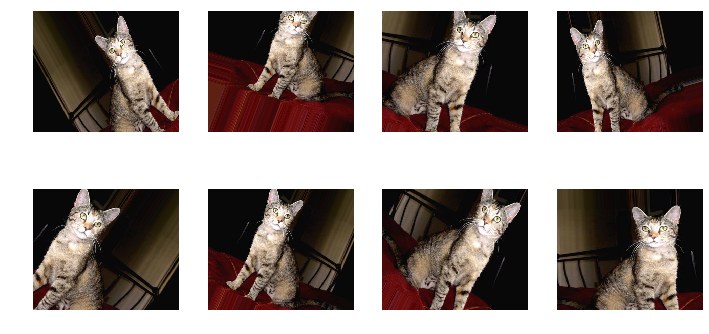

In [8]:
vis.preview_data_aug(DATADIR+'/train/cats/cat.10000.jpg', data_aug, n=8, rows=2)